# Image classification

This tutorial shows how to classify images of renal glomeruli. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,400 images of renal glomeruli. The dataset contains 2 sub-directories, one per class:

```
RENE/Img/
  normal/
  sclerosed/
```

In [2]:
from datetime import datetime    # per calcolare tempi di esecuzione
start_time = datetime.now()

# SET DIR DATASET 
import sys

if sys.platform.startswith('linux'):
    DataSet = '/run/media/gianfranco/Data_SSD/'     
    PathImg = 'DATAset/RENE/Img/'  
elif sys.platform.startswith('win'):
    DataSet = 'E:\\'     
    PathImg = 'DATAset\\RENE\\Img\\' 
    # 'PROVA_COCO\\' ; 'PROVA_VOC\\ImgForClass_TrainVal\\'
else:
    print('altro S.O.')
    
# DIR CON LE IMAMGINI DI TRAIN
data_dir = DataSet + PathImg

NET = 'VGG16'      # or 'VGG16' ; 'AlexNet'
SETname = 'rene'    # or 'Intel' ; 'coco-animals' ; 'VOC2012'

PATH_log = os.path.join(DataSet, 'Logs', NET, SETname)    # path for Logs file

if not os.path.exists(PATH_log):
            os.makedirs(PATH_log)
        
dateTime = datetime.now().strftime("%Y%m%d-%H%M%S")
        
LogsDir = os.path.join(PATH_log, dateTime)

print('PATh log = ', PATH_log)
print('LogsDir  = ', LogsDir)

PATh log =  E:\Logs\VGG16\rene
LogsDir  =  E:\Logs\VGG16\rene\20210918-085507


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print('Total Images in dataset: ', image_count)

Total Images in dataset:  2340


Here are some glomeruli:

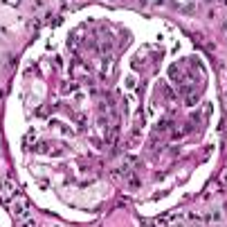

In [4]:
normalGlom = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normalGlom [0]))

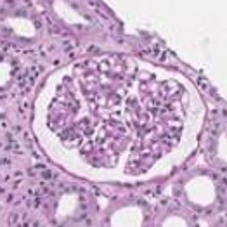

In [5]:
PIL.Image.open(str(normalGlom [1]))

And some tulips:

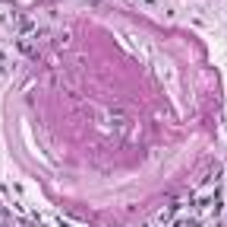

In [6]:
sclerosedGlom = list(data_dir.glob('sclerosed/*'))
PIL.Image.open(str(sclerosedGlom[0]))

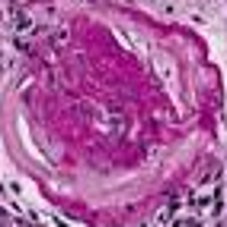

In [7]:
PIL.Image.open(str(sclerosedGlom[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 16
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [11]:
data_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                            #preprocessing_function = std_setVoc,
                                            rescale=1./(255),
                                            validation_split=0.25
                                          )

train_ds = data_image_generator.flow_from_directory(
  data_dir,
  subset="training",
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 1756 images belonging to 2 classes.


In [12]:
val_ds = data_image_generator.flow_from_directory(
  data_dir,
  subset="validation",
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 584 images belonging to 2 classes.


You can find the class names in the `class_names` [Tf 2.6] attribute on these datasets. These correspond to the directory names in alphabetical order.

In [22]:
train_ds.class_indices.keys()

dict_keys(['normal', 'sclerosed'])

## Visualize the data

Here are the first 9 images from the training dataset.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-d17c8cbbcb34>", line 4, in <module>
    for images, labels in train_ds.take(1):
AttributeError: 'DirectoryIterator' object has no attribute 'take'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\e

<Figure size 720x720 with 0 Axes>

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

ERROR! Session/line number was not unique in database. History logging moved to new session 4167
(16, 224, 224, 3)
(16, 2)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-0ccbdac7c5d6>", line 1, in <module>
    AUTOTUNE = tf.data.AUTOTUNE
AttributeError: module 'tensorflow_core._api.v2.data' has no attribute 'AUTOTUNE'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-24e891429889>", line 1, in <module>
    normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'Rescaling'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_geti

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cff4cba101dc>", line 1, in <module>
    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
AttributeError: 'DirectoryIterator' object has no attribute 'map'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 4169
Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cff4cba101dc>", line 1, in <module>
    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
AttributeError: 'DirectoryIterator' object has no attribute 'map'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactive

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-625d8bc25a6f>", line 4, in <module>
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'Rescaling'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
   

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-625d8bc25a6f>", line 4, in <module>
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'Rescaling'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_a

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-180c3339d833>", line 1, in <module>
    model.compile(optimizer='adam',
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ult

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-180c3339d833>", line 1, in <module>
    model.compile(optimizer='adam',
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactives

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-5f15418b3570>", line 1, in <module>
    model.summary()
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-5f15418b3570>", line 1, in <module>
    model.summary()
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-471bb77471a2>", line 2, in <module>
    history = model.fit(
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-471bb77471a2>", line 2, in <module>
    history = model.fit(
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", l

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ab192aeb141e>", line 1, in <module>
    acc = history.history['accuracy']
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ab192aeb141e>", line 1, in <module>
    acc = history.history['accuracy']
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interact

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-c8e0063429ed>", line 3, in <module>
    layers.experimental.preprocessing.RandomFlip("horizontal",
AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'RandomFlip'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-c8e0063429ed>", line 3, in <module>
    layers.experimental.preprocessing.RandomFlip("horizontal",
AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'RandomFlip'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_co

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-458d8c96d07a>", line 2, in <module>
    for images, _ in train_ds.take(1):
AttributeError: 'DirectoryIterator' object has no attribute 'take'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\D

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-458d8c96d07a>", line 2, in <module>
    for images, _ in train_ds.take(1):
AttributeError: 'DirectoryIterator' object has no attribute 'take'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\sit

<Figure size 720x720 with 0 Axes>

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b86568bbbc8f>", line 2, in <module>
    data_augmentation,
NameError: name 'data_augmentation' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultr

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b86568bbbc8f>", line 2, in <module>
    data_augmentation,
NameError: name 'data_augmentation' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactivesh

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-180c3339d833>", line 1, in <module>
    model.compile(optimizer='adam',
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ult

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 4178
Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-180c3339d833>", line 1, in <module>
    model.compile(optimizer='adam',
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code

In [ ]:
model.summary()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-5f15418b3570>", line 1, in <module>
    model.summary()
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 4179
Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-5f15418b3570>", line 1, in <module>
    model.summary()
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-93a11e9ae8ef>", line 2, in <module>
    history = model.fit(
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", l

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ab192aeb141e>", line 1, in <module>
    acc = history.history['accuracy']
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ERROR! Session/line number was not unique in database. History logging moved to new session 4182


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-a846503021fd>", line 10, in <module>
    predictions = model.predict(img_array)
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Anaconda3\envs\DL\lib\site-packages\IPython\